In [38]:
import numpy as np
import pandas as pd
import torch
from torch import nn, optim
from torchvision import datasets, transforms, utils, models
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
import os
from PIL import Image
!pip install torchsummary
import random
from torchsummary import summary
import zipfile
import shutil
plt.style.use('ggplot')
plt.rcParams.update({'font.size': 14, 'axes.labelweight': 'bold', 'axes.grid': False})

In [39]:
# Use gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device.type}")

Using device: cuda


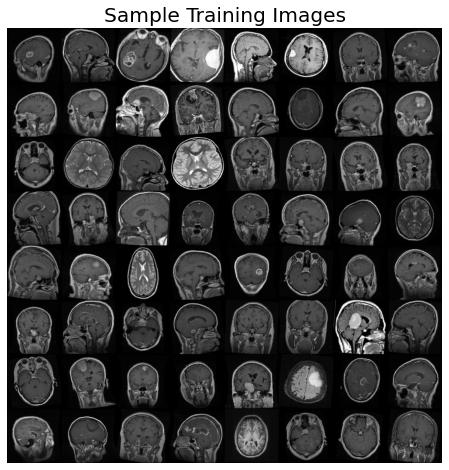

In [40]:
train_dir = "../input/brain-tumor-classification-mri/Training"
valid_dir = "../input/brain-tumor-classification-mri/Testing"


image_size = 230
batch_size = 32

data_transforms = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.ImageFolder(root=train_dir, transform=data_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

valid_dataset = datasets.ImageFolder(root=valid_dir, transform=data_transforms)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

# Plot samples
sample_batch = next(iter(train_loader))
plt.figure(figsize=(10, 8)); plt.axis("off"); plt.title("Sample Training Images")
plt.imshow(np.transpose(utils.make_grid(sample_batch[0], padding=1, normalize=True),(1, 2, 0)));

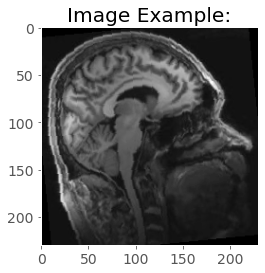

In [41]:
X, y = next(iter(train_loader))
plt.imshow(X[0, 0, :, :], cmap="gray")
plt.title(f"Image Example:");

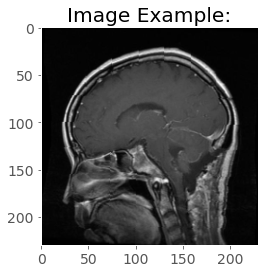

In [42]:
X, y = next(iter(train_loader))
plt.imshow(X[0, 0, :, :] , cmap="gray")
plt.title(f"Image Example:");

In [43]:
print('Training data')
print(f"Classes: {train_dataset.classes}")
print(f"Class count: {train_dataset.targets.count(0)}, {train_dataset.targets.count(1)} , {train_dataset.targets.count(2)}, {train_dataset.targets.count(3)}")
print(f"Samples:",len(train_dataset))

Training data
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class count: 826, 822 , 395, 827
Samples: 2870


In [44]:
print('Testing data')
print(f"Classes: {valid_dataset.classes}")
print(f"Class count: {valid_dataset.targets.count(0)}, {valid_dataset.targets.count(1)} , {valid_dataset.targets.count(2)}, {valid_dataset.targets.count(3)}")
print(f"Samples:",len(valid_dataset))

Testing data
Classes: ['glioma_tumor', 'meningioma_tumor', 'no_tumor', 'pituitary_tumor']
Class count: 100, 115 , 105, 74
Samples: 394


In [45]:
class brain_tumour_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            
            nn.Conv2d(3, 64, (3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.35),
            
            nn.Conv2d(64, 64, (3, 3)),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Dropout(0.35),
            
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.BatchNorm2d(64),
            nn.Dropout(0.35),
            
            nn.Conv2d(64, 64, (3, 3)),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(0.35),
            
            nn.Flatten(),
            nn.Dropout(0.35),
            nn.Linear(179776, 512),
            nn.ReLU(),
            nn.Linear(512, 4)
        
        )
        
        
    def forward(self, x):
        out = self.main(x)
        return out

In [46]:
model = brain_tumour_CNN()
model.to(device)
summary(model,(3,image_size, image_size));

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 228, 228]           1,792
       BatchNorm2d-2         [-1, 64, 228, 228]             128
              ReLU-3         [-1, 64, 228, 228]               0
           Dropout-4         [-1, 64, 228, 228]               0
            Conv2d-5         [-1, 64, 226, 226]          36,928
       BatchNorm2d-6         [-1, 64, 226, 226]             128
              ReLU-7         [-1, 64, 226, 226]               0
         MaxPool2d-8         [-1, 64, 113, 113]               0
           Dropout-9         [-1, 64, 113, 113]               0
           Conv2d-10         [-1, 64, 111, 111]          36,928
             ReLU-11         [-1, 64, 111, 111]               0
        MaxPool2d-12           [-1, 64, 55, 55]               0
      BatchNorm2d-13           [-1, 64, 55, 55]             128
          Dropout-14           [-1, 64,

In [47]:
def trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=5, verbose=True):
    
    print('Training started:\n')
    
    train_loss, valid_loss, train_accuracy, valid_accuracy = [], [], [], []
    
    for epoch in range(epochs):  
        train_batch_loss = 0
        train_batch_acc = 0
        valid_batch_loss = 0
        valid_batch_acc = 0
        
        # Training
        model.train()
        for X, y in train_loader:
            X, y = X.to(device), y.to(device)
            optimizer.zero_grad()
            y_hat = model(X)
            _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
            loss = criterion(y_hat, y)
            loss.backward()
            optimizer.step()
            train_batch_loss += loss.item()
            train_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        
        train_loss.append(train_batch_loss / len(train_loader))
        train_accuracy.append(train_batch_acc / len(train_loader))
        
        # Validation
        model.eval()
        with torch.no_grad():  
            for X, y in valid_loader:
                X, y = X.to(device), y.to(device)
                y_hat = model(X)
                _, y_hat_labels = torch.softmax(y_hat, dim=1).topk(1, dim=1)
                loss = criterion(y_hat, y)
                valid_batch_loss += loss.item()
                valid_batch_acc += (y_hat_labels.squeeze() == y).type(torch.float32).mean().item()
        
        valid_loss.append(valid_batch_loss / len(valid_loader))
        valid_accuracy.append(valid_batch_acc / len(valid_loader))
        
        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}",
                  f"Train Accuracy: {train_accuracy[-1]:.2f}",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}")
    
    results = {"train_loss": train_loss,
               "train_accuracy": train_accuracy,
               "valid_loss": valid_loss,
               "valid_accuracy": valid_accuracy}
    return results

In [48]:
torch.cuda.empty_cache()

In [49]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)
results = trainer(model, criterion, optimizer, train_loader, valid_loader, device, epochs=15)

Training started:

Epoch 1: Train Loss: 1.919 Train Accuracy: 0.61 Valid Loss: 4.871. Valid Accuracy: 0.29
Epoch 2: Train Loss: 0.714 Train Accuracy: 0.72 Valid Loss: 3.443. Valid Accuracy: 0.27
Epoch 3: Train Loss: 0.660 Train Accuracy: 0.75 Valid Loss: 2.798. Valid Accuracy: 0.35
Epoch 4: Train Loss: 0.548 Train Accuracy: 0.78 Valid Loss: 3.004. Valid Accuracy: 0.33
Epoch 5: Train Loss: 0.502 Train Accuracy: 0.80 Valid Loss: 1.803. Valid Accuracy: 0.51
Epoch 6: Train Loss: 0.508 Train Accuracy: 0.80 Valid Loss: 3.581. Valid Accuracy: 0.40
Epoch 7: Train Loss: 0.448 Train Accuracy: 0.82 Valid Loss: 2.255. Valid Accuracy: 0.45
Epoch 8: Train Loss: 0.446 Train Accuracy: 0.82 Valid Loss: 1.585. Valid Accuracy: 0.52
Epoch 9: Train Loss: 0.450 Train Accuracy: 0.82 Valid Loss: 1.912. Valid Accuracy: 0.41
Epoch 10: Train Loss: 0.382 Train Accuracy: 0.84 Valid Loss: 2.228. Valid Accuracy: 0.43
Epoch 11: Train Loss: 0.396 Train Accuracy: 0.84 Valid Loss: 2.100. Valid Accuracy: 0.48
Epoch 12: T

In [62]:
alexnet = models.alexnet(pretrained=True)
alexnet.eval();

#for param in alexnet.parameters():
#    param.requires_grad = False

In [63]:
alexnet.to(device)
optimizer = optim.Adam(alexnet.parameters(), lr=2e-3)
results = trainer(alexnet, criterion, optimizer, train_loader, valid_loader, device, epochs=15)

Training started:

Epoch 1: Train Loss: 3.933 Train Accuracy: 0.28 Valid Loss: 1.554. Valid Accuracy: 0.14
Epoch 2: Train Loss: 1.378 Train Accuracy: 0.31 Valid Loss: 1.598. Valid Accuracy: 0.20
Epoch 3: Train Loss: 1.317 Train Accuracy: 0.36 Valid Loss: 1.540. Valid Accuracy: 0.27
Epoch 4: Train Loss: 1.360 Train Accuracy: 0.28 Valid Loss: 1.393. Valid Accuracy: 0.33
Epoch 5: Train Loss: 1.377 Train Accuracy: 0.29 Valid Loss: 1.509. Valid Accuracy: 0.18
Epoch 6: Train Loss: 1.361 Train Accuracy: 0.28 Valid Loss: 1.451. Valid Accuracy: 0.20
Epoch 7: Train Loss: 1.354 Train Accuracy: 0.28 Valid Loss: 1.525. Valid Accuracy: 0.25
Epoch 8: Train Loss: 1.356 Train Accuracy: 0.29 Valid Loss: 1.492. Valid Accuracy: 0.19
Epoch 9: Train Loss: 1.355 Train Accuracy: 0.30 Valid Loss: 1.468. Valid Accuracy: 0.18
Epoch 10: Train Loss: 1.359 Train Accuracy: 0.27 Valid Loss: 1.468. Valid Accuracy: 0.20
Epoch 11: Train Loss: 1.360 Train Accuracy: 0.28 Valid Loss: 1.456. Valid Accuracy: 0.27
Epoch 12: T

KeyboardInterrupt: 

In [50]:
#plt.plot(np.array(results['train_loss']), label='Train Loss')
#plt.plot(np.array(results['valid_loss']), label='Validation Loss')
#plt.xlabel("Epoch")
#plt.ylabel("Loss")
#plt.legend();

In [51]:
#plt.plot(np.array(results['train_accuracy']), label='Train Accuracy')
#plt.plot(np.array(results['valid_accuracy']), label='Validation Accuracy')
#plt.xlabel("Epoch")
#plt.ylabel("Accuracy")
#plt.legend();